# Make data dictionaries

In [2]:
import yaml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [3]:
# assumes cwd is the space-data root

# read data dict
with open('notebooks/data_dict.yaml', "r") as f:
    data_dict = yaml.load(f, Loader=yaml.SafeLoader)

# read templates
with open('notebooks/templates.yaml', "r") as f:
    templates = yaml.load(f, Loader=yaml.SafeLoader)

In [4]:
def make_corr_plots(df, figname):
    corr = df.corr()
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 10))
    fig = sns.heatmap(corr, ax=ax)
    f.tight_layout()
    fig.get_figure().savefig("data_collections/" + figname)

In [5]:
def get_df_overview(df, basename, overview, template):
    pd_overview = template.format(
        len(df.columns),
        len(df),
        df.isna().any(axis=1).sum(),
        round(df.isna().any(axis=1).sum() / len(df) * 100, 2),
        df.duplicated().sum(),
        df.duplicated().sum() / len(df) * 100,
        round(df.memory_usage(deep=True).sum() / (1024**2), 2),
    )

    lines = pd_overview.strip().split("\n")

    # Parse each line into a key-value pair
    for line in lines:
        key, value = line.strip().split(":", 1)
        key = key.strip("' ")  # remove leading/trailing whitespace and single quotes
        value = value.strip(
            "' ,"
        )  # remove leading/trailing whitespace, single quotes and comma
        overview[key] = value
    return overview

In [6]:
def get_data_dict(var_list):
    data_dict_str = [
        "| Variable Name | Description |",
        "| ------------- | ----------- |",
    ]
    for key, value in var_list:
        data_dict_str.append(f"| `{key}` | {value} |")
    return data_dict_str

In [7]:
# data_dict = utils.data_dict
overview_template = templates["overview_temp"]
data_dict_template = templates["data_dict_temp"]

  0%|          | 0/6 [00:00<?, ?it/s]

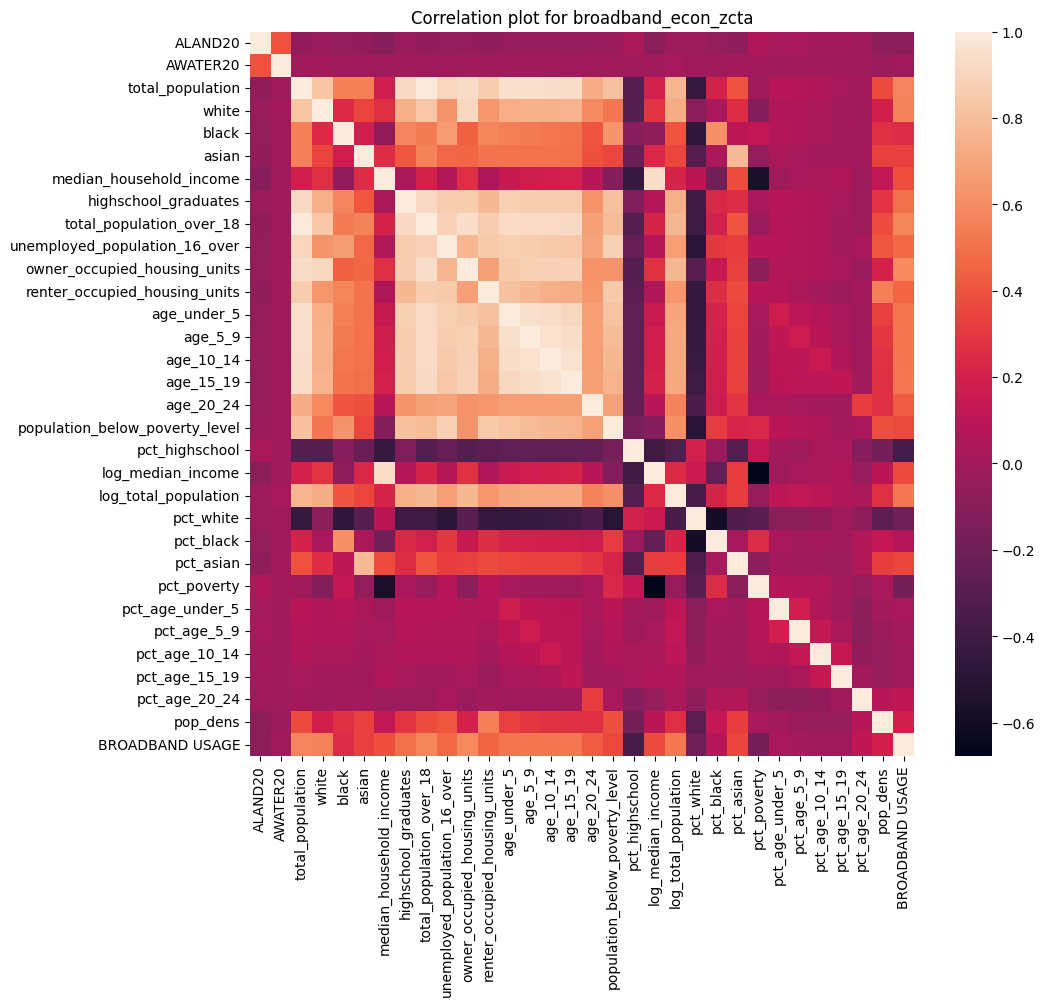

 17%|█▋        | 1/6 [00:00<00:03,  1.58it/s]

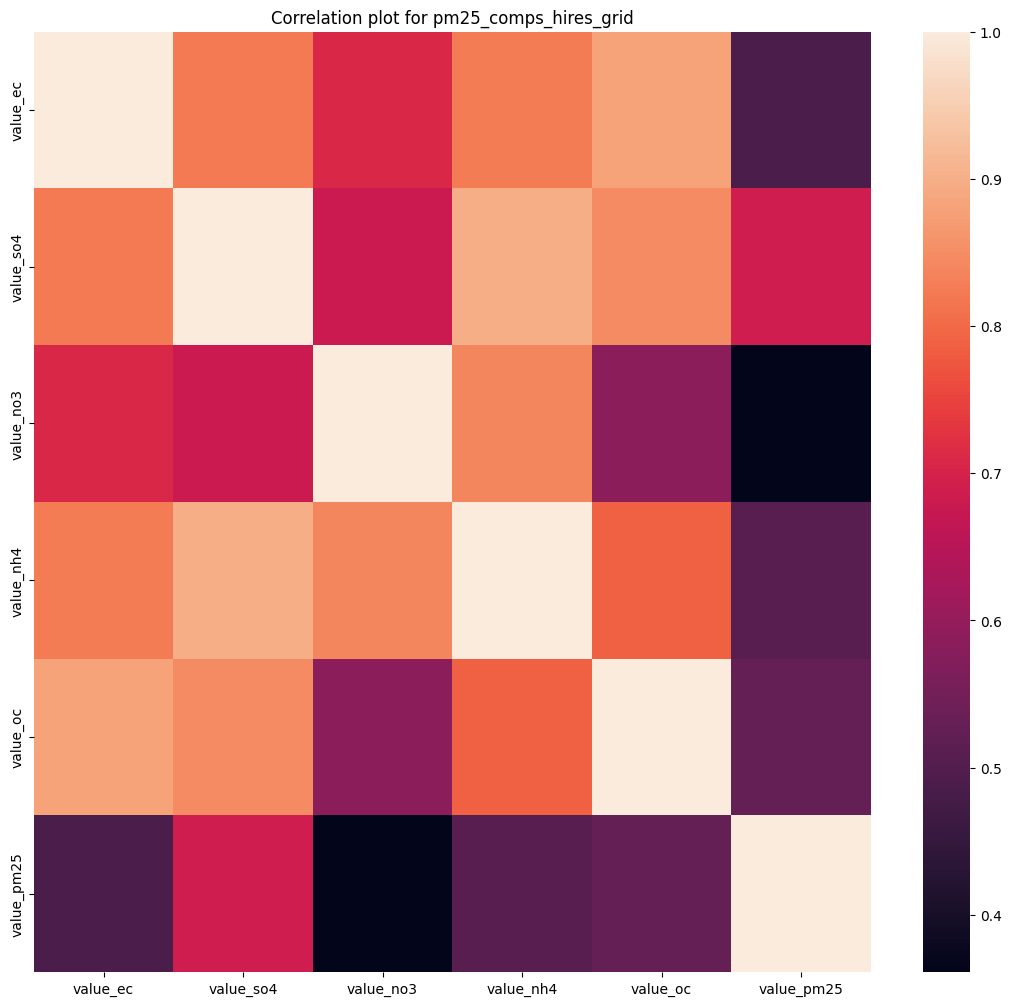

 33%|███▎      | 2/6 [00:08<00:20,  5.02s/it]

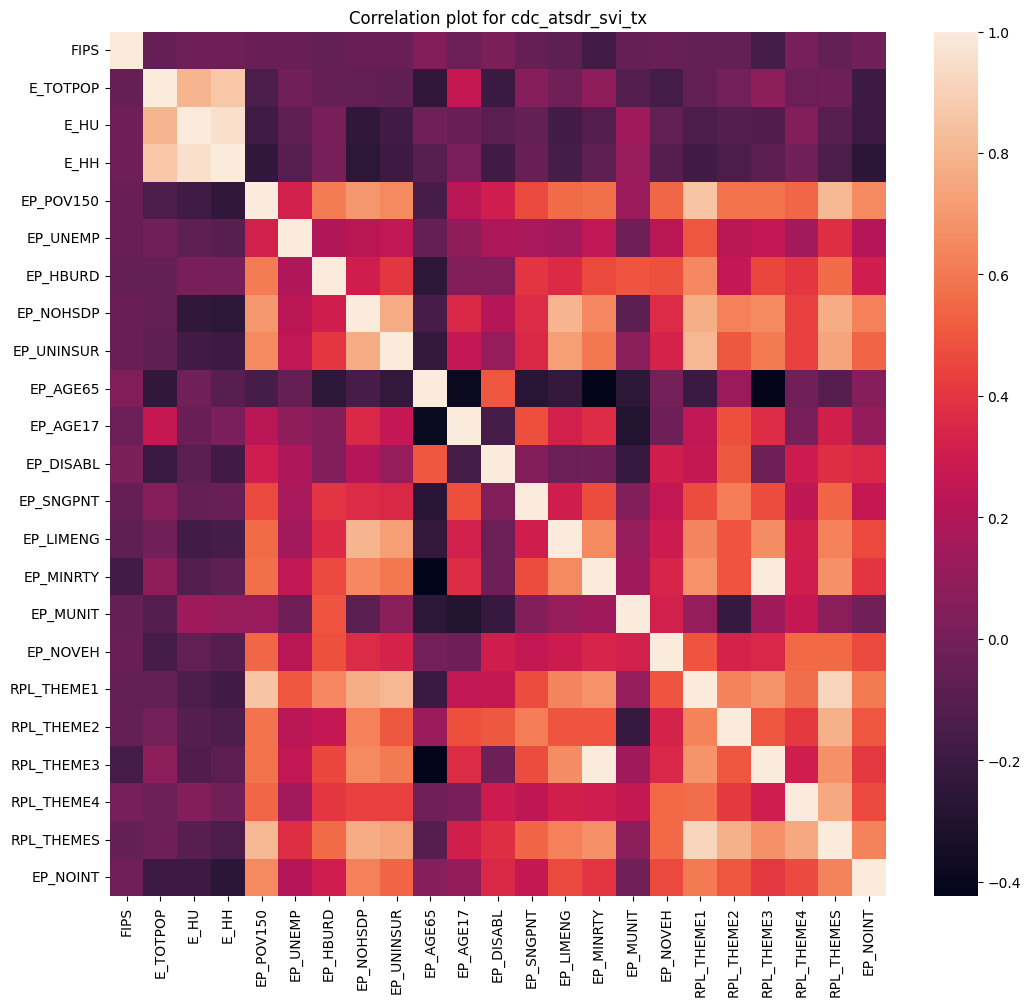

 50%|█████     | 3/6 [00:09<00:08,  2.91s/it]

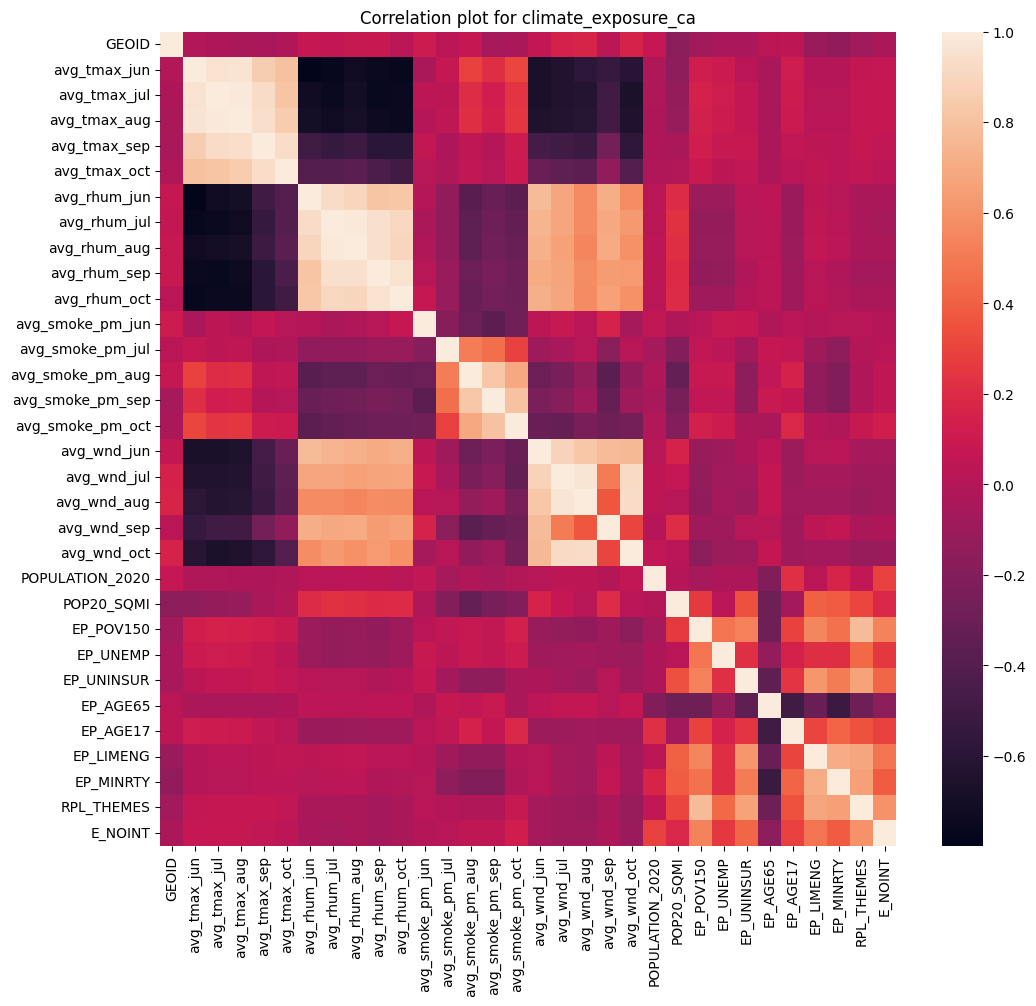

 67%|██████▋   | 4/6 [00:09<00:03,  1.94s/it]/var/folders/h3/2f91vbwj7r506n1w06610njh0000gn/T/ipykernel_1189/2135297523.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


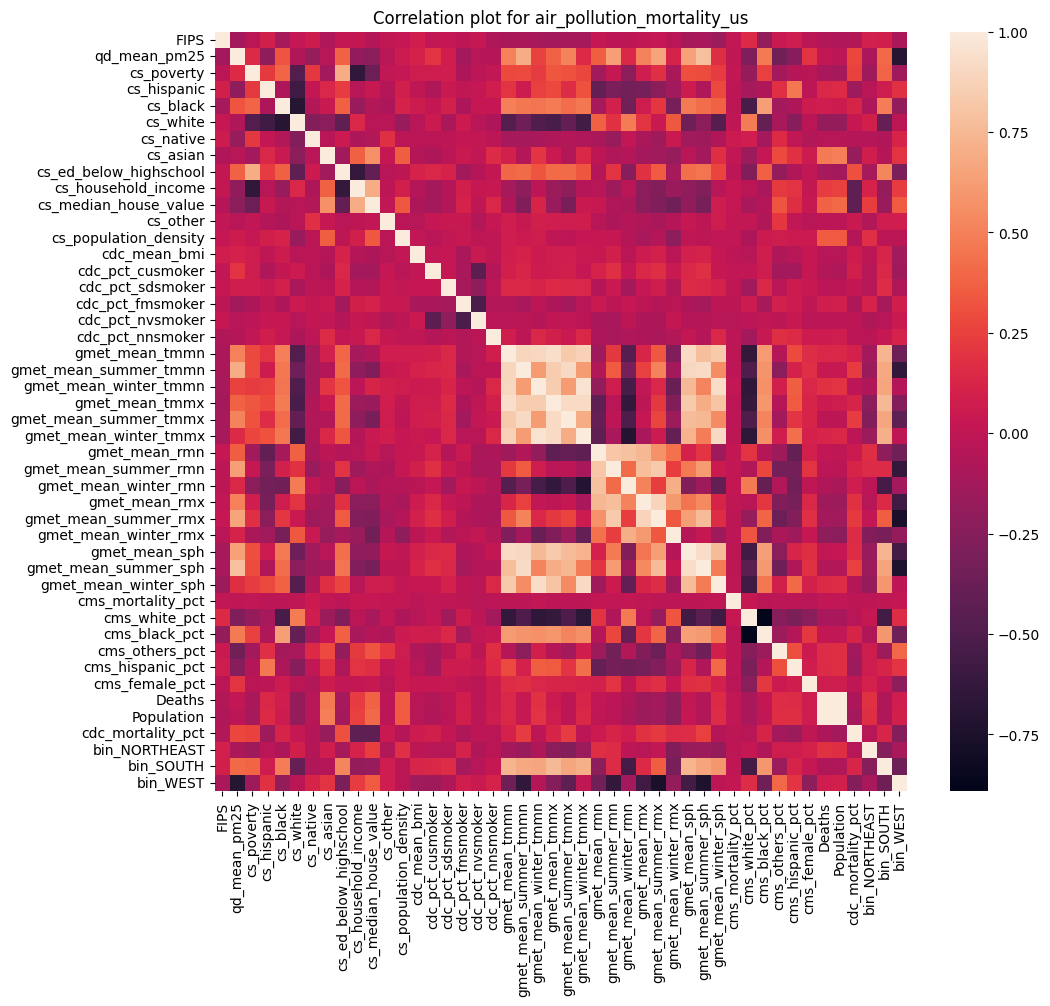

 83%|████████▎ | 5/6 [00:10<00:01,  1.46s/it]

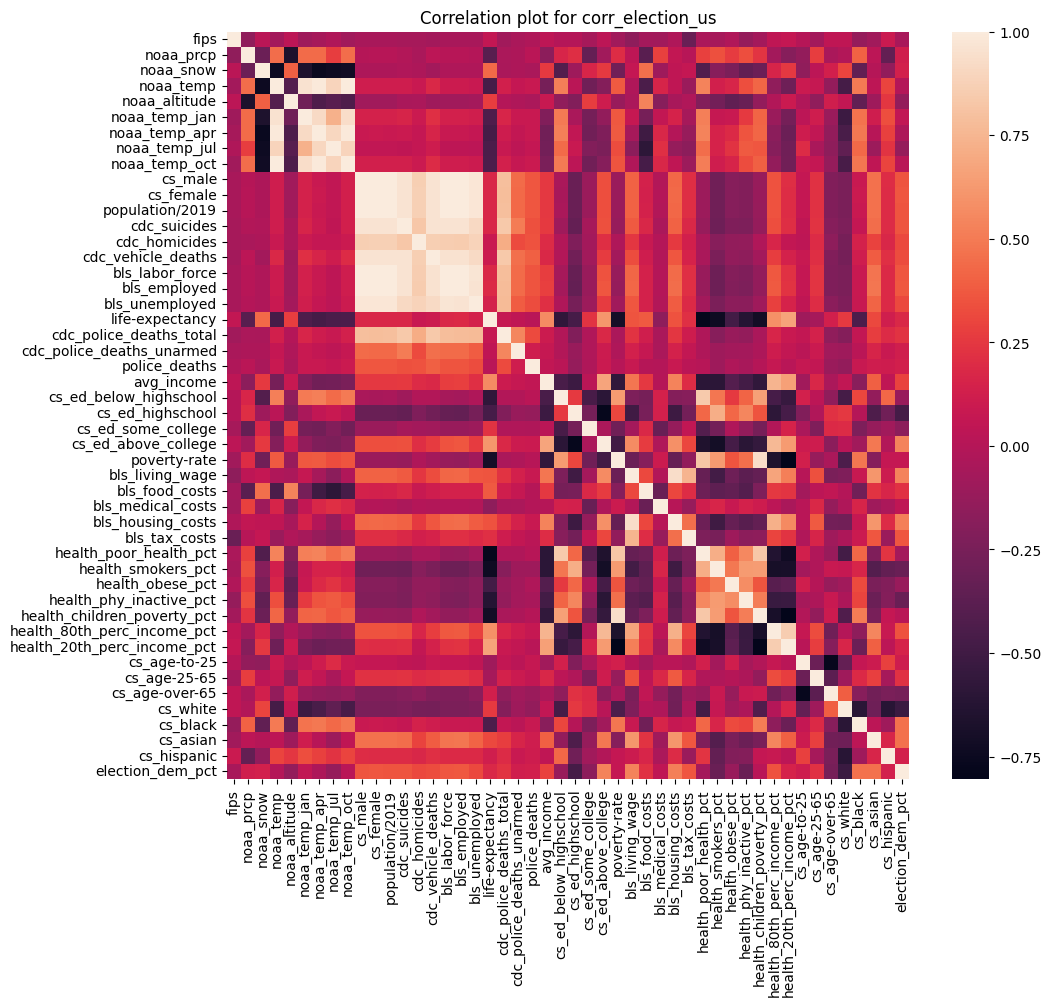

100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


In [8]:
for base_name, fields in tqdm(data_dict.items()):
    data_dict_str = get_data_dict(fields["var_list"].items())

    data_frame_path = fields["data_path"]
    if data_frame_path.endswith(".csv"):
        df = pd.read_csv(data_frame_path)
    elif data_frame_path.endswith(".tab"):
        df = pd.read_csv(data_frame_path, sep="\t")
    elif data_frame_path.endswith(".parquet"):
        df = pd.read_parquet(data_frame_path)
    else:
        raise ValueError(f"Unknown file type for {data_frame_path}")

    overview = get_df_overview(df, base_name, fields["overview"], overview_template)

    figname = f"figs/corr_{base_name}.png"
    make_corr_plots(df, figname)
    plt.title(f"Correlation plot for {base_name}")
    plt.show()

    data_dict_md = data_dict_template.format(
        pd.DataFrame(
            overview.items(),
            columns=["Properties", "Value"],
        ).to_markdown(index=False),
        "\n".join(data_dict_str),
        figname,
        df.head().to_markdown(index=False),
    )

    with open("data_collections/docs_{}.md".format(base_name), "w") as f:
        f.write(data_dict_md)